<a href="https://colab.research.google.com/github/yl3506/RushHour/blob/master/LMM_int.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Linear Mixed Effects Models

<table class="tfo-notebook-buttons" align="left">
</table>


A linear mixed effects model is a simple approach for modeling structured linear relationships (Harville, 1997; Laird and Ware, 1982). Each data point consists of inputs of varying type—categorized into groups—and a real-valued output. A linear mixed effects model is a _hierarchical model_: it shares statistical strength across groups in order to improve inferences about any individual data point.

We demonstrate linear mixed effects models with data from RushHour. We'll use the Edward2 (`tfp.edward2`) and Markov Chain Monte Carlo (`tfp.mcmc`) modules from TensorFlow Probability.

In [0]:
!pip install -q tensorflow-probability

In [0]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
import tensorflow_probability as tfp
import warnings
import sklearn

from tensorflow_probability import edward2 as ed

plt.style.use('ggplot')

In [570]:
# target data
humanlen = np.expand_dims(np.load('humanlen_list.npy'), axis = 1)
print(humanlen.shape)
# fixed features
x1 = np.expand_dims(np.load('y_avgDepthSol.npy'), axis = 1)
x2 = np.expand_dims(np.load('y_avgEdgeSol.npy'), axis = 1)
x3 = np.expand_dims(np.load('y_avgMaxCycleSol.npy'), axis = 1)
x4 = np.expand_dims(np.load('y_avgNodeSol.npy'), axis = 1)
x5 = np.expand_dims(np.load('y_avgcNodeSol.npy'), axis = 1)
x6 = np.expand_dims(np.load('y_avgnCycleSol.npy'), axis = 1)
x7 = np.expand_dims(np.load('y_backMoveSol.npy'), axis = 1)
x8 = np.expand_dims(np.load('y_edgeRate.npy'), axis = 1)
x9 = np.expand_dims(np.load('y_nodeRate.npy'), axis = 1)
x10 = np.expand_dims(np.load('y_unsafeSol.npy'), axis = 1)
print("Randomly check one feature's shape:", x5.shape)
# random feature
xr = np.expand_dims(np.load('sub_list.npy'), axis = 1) 
print("Check random feature's shape:", xr.shape)


(2257, 1)
Randomly check one feature's shape: (2257, 1)
Check random feature's shape: (2257, 1)


## Data

We use the data from RushHour project. It is a data set of RushHour MAG features and human solution length. Each subject trial includes metadata such as `avgDepthSol`, `avgEdgeSol`, and `sublist`, and the response variable of interest is the human solution length.

In [571]:
# load and normalize data
data = np.concatenate((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10), axis = 1)
data = sklearn.preprocessing.normalize(data, axis = 0) # 1 across trials, 0 across features
data = np.concatenate((data, xr, humanlen), axis = 1)
print("raw data shape:", data.shape)
# adjust data labels
metadata = {'columns': ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 
                        'x7', 'x8', 'x9', 'x10', 'xr', 'y']}
data = pd.DataFrame(data, columns = metadata['columns'])
data = data.rename(columns = {'x1': 'avgDepthSol', # average depth from red in soltion
                              'x2': 'avgEdgeSol', # average number of edges in solution
                              'x3': 'avgMaxCycleSol', # average maximum cycle size in solution
                              'x4': 'avgNodeSol', # average number of nodes in solution
                              'x5': 'avgcNodeSol', # average number of nodes in cycle in solution
                              'x6': 'avgnCycleSol', # average number of cycles in solution
                              'x7': 'backMoveSol', # average number of backward moves in solution
                              'x8': 'edgeRate', # average edge decrease rate 
                              'x9': 'nodeRate', # average node decrease rate
                              'x10': 'unsafeSol', # number of unsafe moves in solution
                              'xr': 'sublist', # which subject this trial belongs to
                              'y': 'humanlen'}) # target human len
# encode sublist into categorical integers
data['sublist'] = data['sublist'].astype('category').cat.codes
# 85% training data, 15% testing data
train = data.sample(frac = 0.85)
test = data.drop(train.index)
# show 5 training samples
train.head()

raw data shape: (2257, 12)


,avgDepthSol,avgEdgeSol,avgMaxCycleSol,avgNodeSol,avgcNodeSol,avgnCycleSol,backMoveSol,edgeRate,nodeRate,unsafeSol,sublist,humanlen
1723,0.022431159208662576,0.021866825677113424,0.008002952560619453,0.022480114923444178,0.009854941795609095,0.006364426192405288,0.03604517754032265,0.02099582118794063,0.02045571540960454,0.013320516991091826,33,28
1571,0.018552086563555514,0.008590538658865988,0.014672079694468997,0.012246310224961972,0.013765632984342862,0.022502792608861556,0.0,0.030636759488525612,0.03214469564366428,0.0,29,7
711,0.022431159208662576,0.021866825677113424,0.008002952560619453,0.022480114923444178,0.009854941795609095,0.006364426192405288,0.03604517754032265,0.02099582118794063,0.02045571540960454,0.013320516991091826,13,35
197,0.020407295219911064,0.0160246586521154,0.004192022769848285,0.019075983235036918,0.005162112369128573,0.002500310289873506,0.028321210924539226,0.011783369034048313,0.014286531397184122,0.010466120493000719,3,25
1510,0.02184086554527672,0.019553988345880274,0.006669127133849544,0.019482766266984954,0.00875994826276364,0.01591106548101322,0.03604517754032265,0.02399522421478929,0.02045571540960454,0.0,28,41


We load and preprocess the data set. We hold out 15% of the data so we can evaluate our fitted model on unseen data points. Below we visualize the first few rows.

We set up the data set in terms of a `features` dictionary of inputs and a `labels` output corresponding to the humanlen. Each feature and each label (humanlen) is encoded as a floating point number. Each sublist is encoded as an integer.

In [572]:
# helper function
get_value = lambda dataframe, key, dtype: dataframe[key].values.astype(dtype)

# generate training data
features_train = {k: get_value(train, key=k, dtype=np.float32)
                 for k in ['avgDepthSol', 'avgEdgeSol', 'avgMaxCycleSol', 'avgNodeSol', 
                           'avgcNodeSol', 'avgnCycleSol', 'backMoveSol', 'edgeRate',
                           'nodeRate', 'unsafeSol']}
features_train['sublist'] = get_value(train, key='sublist', dtype=np.int32)
labels_train = get_value(train, key='humanlen', dtype=np.float32)
print("Each training feature's size:", features_train['avgDepthSol'].shape)
print("Training target/label's size:", labels_train.shape)

# generate testing data 
features_test = {k: get_value(test, key=k, dtype=np.float32)
                 for k in ['avgDepthSol', 'avgEdgeSol', 'avgMaxCycleSol', 'avgNodeSol', 
                           'avgcNodeSol', 'avgnCycleSol', 'backMoveSol', 'edgeRate',
                           'nodeRate', 'unsafeSol']}
features_test['sublist'] = get_value(test, key='sublist', dtype=np.int32)
labels_test = get_value(test, key='humanlen', dtype=np.float32)
print("Each testing feature's size:", features_test['avgDepthSol'].shape)
print("Testing target/label's size:", labels_test.shape)

Each training feature's size: (1918,)
Training target/label's size: (1918,)
Each testing feature's size: (339,)
Testing target/label's size: (339,)


In [573]:
num_sublist = max(features_train['sublist']) + 1
print('Number of subject categories:', num_sublist)
print("Number of training samples:", train.shape[0])

Number of subject categories: 42
Number of training samples: 1918


## Model

A typical linear model assumes independence, where any pair of data points has a constant linear relationship. In the RushHour data set, observations arise in groups each of which may have varying slopes and intercepts. Linear mixed effects models, also known as hierarchical linear models or multilevel linear models, capture this phenomenon (Gelman & Hill, 2006). 

__For this model, we consider only random intercept, no random slope yet.__

Examples of this phenomenon include:

+ __Sublist__. Observations from the same subject are not independent: some subject may systematically have higher human solution length.

To capture this, recall that for a data set of $N\times D$ features $\mathbf{X}$ and $N$ labels $\mathbf{y}$, linear regression posits the model

\begin{equation*}
\mathbf{y} = \mathbf{X}\beta + \alpha + \epsilon,
\end{equation*}

where there is a slope vector $\beta\in\mathbb{R}^D$, intercept $\alpha\in\mathbb{R}$, and random noise $\epsilon\sim\text{Normal}(\mathbf{0}, \mathbf{I})$. We say that $\beta$ and $\alpha$ are "fixed effects": they are effects held constant across the population of data points $(x, y)$. An equivalent formulation of the equation as a likelihood is $\mathbf{y} \sim \text{Normal}(\mathbf{X}\beta + \alpha, \mathbf{I})$. This likelihood is maximized during inference in order to find point estimates of $\beta$ and $\alpha$ that fit the data.

A linear mixed effects model extends linear regression as

\begin{align*}
\eta &\sim \text{Normal}(\mathbf{0}, \sigma^2 \mathbf{I}), \\
\mathbf{y} &= \mathbf{X}\beta + \mathbf{Z}\eta + \alpha + \epsilon.
\end{align*}

where there is still a slope vector $\beta\in\mathbb{R}^P$, intercept $\alpha\in\mathbb{R}$, and random noise $\epsilon\sim\text{Normal}(\mathbf{0}, \mathbf{I})$. In addition, there is a term $\mathbf{Z}\eta$, where $\mathbf{Z}$ is a features matrix and $\eta\in\mathbb{R}^Q$ is a vector of random slopes; $\eta$ is normally distributed with variance component parameter $\sigma^2$. $\mathbf{Z}$ is formed by partitioning the original $N\times D$ features matrix in terms of a new $N\times P$ matrix $\mathbf{X}$ and $N\times Q$ matrix $\mathbf{Z}$, where $P + Q=D$: this partition allows us to model the features separately using the fixed effects $\beta$ and the latent variable $\eta$ respectively.

We say the latent variables $\eta$ are "random effects": they are effects that vary across the population (although they may be constant across subpopulations). In particular, because the random effects $\eta$ have mean 0, the data label's mean is captured by $\mathbf{X}\beta + \alpha$. The random effects component $\mathbf{Z}\eta$ captures variations in the data: for example, "Subject \#21 performed 5 moves more than the mean human length."

We posit the following effects:

+ Fixed effects: 
`avgDepthSol`, average depth from red in soltion. 
`avgEdgeSol`, average number of edges in solution.
`avgMaxCycleSol`, average maximum cycle size in solution.
`avgNodeSol`, average number of nodes in solution.
`avgcNodeSol`, average number of nodes in cycle in solution.
`avgnCycleSol`, average number of cycles in solution.
`backMoveSol`, average number of backward moves in solution.
`edgeRate`, average edge decrease rate.
`nodeRate`, average node decrease rate.
`unsafeSol`, number of unsafe moves in solution.
+ Random effects: `sublist`. Given more observations from the population of subject trials, we may be looking at new subjects.

In the syntax of R's lme4 package (Bates et al., 2015), the model can be summarized as

```
humanlen ~ avgDepthSol + avgEdgeSol + avgMaxCycleSol + avgNodeSol + avgcNodeSol + avgnCycleSol + backMoveSol + edgeRate + nodeRate + unsafeSol + (1|subject) + 1
```
where `x` denotes a fixed effect,`(1|x)` denotes a random effect for `x`, and `1` denotes an intercept term.

We implement this model below as an Edward program.

In [0]:
def linear_mixed_effects_model(features):
  # Set up fixed effects and other parameters.
  intercept = tf.get_variable("intercept", [])  # alpha in eq
  all_features = ['avgDepthSol', 'avgEdgeSol', 'avgMaxCycleSol', 'avgNodeSol', 
                   'avgcNodeSol', 'avgnCycleSol', 'backMoveSol', 'edgeRate',
                   'nodeRate', 'unsafeSol']
  effect_avgDepthSol = tf.get_variable("effect_avgDepthSol", [])  # beta in eq
  effect_avgEdgeSol = tf.get_variable("effect_avgEdgeSol", [])
  effect_avgMaxCycleSol = tf.get_variable("effect_avgMaxCycleSol", [])
  effect_avgNodeSol = tf.get_variable("effect_avgNodeSol", [])
  effect_avgcNodeSol = tf.get_variable("effect_avgcNodeSol", [])
  effect_avgnCycleSol = tf.get_variable("effect_avgnCycleSol", [])
  effect_backMoveSol = tf.get_variable("effect_backMoveSol", [])
  effect_edgeRate = tf.get_variable("effect_edgeRate", [])
  effect_nodeRate = tf.get_variable("effect_nodeRate", [])
  effect_unsafeSol = tf.get_variable("effect_unsafeSol", [])
  stddev_sublist = tf.exp(
      tf.get_variable("stddev_unconstrained_sublist", [])) # sigma in eq
  

  # Set up random effects.
  effect_sublist = ed.MultivariateNormalDiag(
      loc=tf.zeros(num_sublist),
      scale_identity_multiplier=stddev_sublist,
      name="effect_sublist")
#   effect_sublist = ed.Normal(
#                     loc = tf.zeros(num_sublist),
#                     scale = stddev_sublist,
#                     name="effect_sublist")

  

  # Set up likelihood given fixed and random effects.
  # Note we use `tf.gather` instead of matrix-multiplying a design matrix of
  # one-hot vectors. The latter is memory-intensive if there are many groups.
  humanlen = ed.Normal(
      loc=(effect_avgDepthSol * features["avgDepthSol"] +
           effect_avgEdgeSol * features["avgEdgeSol"] +
           effect_avgMaxCycleSol * features["avgMaxCycleSol"] +
           effect_avgNodeSol * features["avgNodeSol"] +
           effect_avgcNodeSol * features["avgcNodeSol"] +
           effect_avgnCycleSol * features["avgnCycleSol"] +
           effect_backMoveSol * features["backMoveSol"] +
           effect_edgeRate * features["edgeRate"] +
           effect_nodeRate * features["nodeRate"] +
           effect_unsafeSol * features["unsafeSol"] +
           tf.gather(effect_sublist, features["sublist"]) +
           intercept),
      scale=1.,
      name="humanlen")
  return humanlen

# Wrap model in a template. All calls to the model template will use the same
# TensorFlow variables.
model_template = tf.make_template("model", linear_mixed_effects_model)

As an Edward program, we can also visualize the model's structure in terms of its computational graph. This graph encodes dataflow across the random variables in the program, making explicit their relationships in terms of a graphical model (Jordan, 2003).

As a statistical tool, we might look at the graph in order to better see, for example, that `intercept` and `effect_avgDepthSol` are conditionally dependent given `humanlen`; this may be harder to see from the source code if the program is written with classes, cross references across modules, and/or subroutines. As a computational tool, we might also notice latent variables flow into the `humanlen` variable via `tf.gather` ops. This may be a bottleneck on certain hardware accelerators if indexing `Tensor`s is expensive; visualizing the graph makes this readily apparent.


In [575]:
# visualize model relationship
def strip_consts(graph_def, max_const_size=32):
  """Strip large constant values from graph_def."""
  strip_def = tf.GraphDef()
  for n0 in graph_def.node:
    n = strip_def.node.add()
    n.MergeFrom(n0)
    if n.op == 'Const':
      tensor = n.attr['value'].tensor
      size = len(tensor.tensor_content)
      if size > max_const_size:
        tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
  return strip_def

def draw_graph(model, *args, **kwargs):
  """Visualize TensorFlow graph."""
  graph = tf.Graph()
  with graph.as_default():
    model(*args, **kwargs)
  graph_def = graph.as_graph_def()
  strip_def = strip_consts(graph_def, max_const_size=32)
  code = """
      <script>
        function load() {{
          document.getElementById("{id}").pbtxt = {data};
        }}
      </script>
      <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
      <div style="height:600px">
        <tf-graph-basic id="{id}"></tf-graph-basic>
      </div>
  """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

  iframe = """
      <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
  """.format(code.replace('"', '&quot;'))
  IPython.display.display(IPython.display.HTML(iframe))


draw_graph(linear_mixed_effects_model, features_train)

## Parameter Estimation

Given data, the goal of inference is to fit the model's fixed effects slope $\beta$, intercept $\alpha$, and variance component parameter $\sigma^2$. The maximum likelihood principle formalizes this task as

$$
\max_{\beta, \alpha, \sigma}~\log p(\mathbf{y}\mid \mathbf{X}, \mathbf{Z}; \beta, \alpha, \sigma) = \max_{\beta, \alpha, \sigma}~\log \int p(\eta; \sigma) ~p(\mathbf{y}\mid \mathbf{X}, \mathbf{Z}, \eta; \beta, \alpha)~d\eta.
$$

We use the Monte Carlo EM algorithm to maximize this marginal density (Dempster et al., 1977; Wei and Tanner, 1990).¹ We perform Markov chain Monte Carlo to compute the expectation of the conditional likelihood with respect to the random effects ("E-step"), and we perform gradient descent to maximize the expectation with respect to the parameters ("M-step"):

+ For the E-step, we set up Hamiltonian Monte Carlo (HMC). It takes a current state—the sublist effect—and returns a new state. We assign the new state to TensorFlow variables, which will denote the state of the HMC chain.

+ For the M-step, we use the posterior sample from HMC to calculate an unbiased estimate of the marginal likelihood up to a constant. We then apply its gradient with respect to the parameters of interest. This produces an unbiased stochastic descent step on the marginal likelihood. We implement it with the Adam TensorFlow optimizer and minimize the negative of the marginal.

In [0]:
log_joint = ed.make_log_joint_fn(model_template)

def target_log_prob_fn(effect_sublist):
  """Unnormalized target density as a function of states."""
  return log_joint(  # fix `features` and `humanlen` to the training data
    features=features_train,
    effect_sublist=effect_sublist,
    humanlen=labels_train)

tf.reset_default_graph()

all_features = ['avgDepthSol', 'avgEdgeSol', 'avgMaxCycleSol', 'avgNodeSol', 
                   'avgcNodeSol', 'avgnCycleSol', 'backMoveSol', 'edgeRate',
                   'nodeRate', 'unsafeSol']
# Set up E-step (MCMC).
effect_sublist = tf.get_variable(  # `trainable=False` so unaffected by M-step
    "effect_sublist", [num_sublist], trainable=False)
# effect_avgDepthSol = tf.get_variable(  
#     "effect_avgDepthSol", [], trainable=True)


hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.15,
    num_leapfrog_steps=3)

current_state = [effect_sublist]
next_state, kernel_results = hmc.one_step(
      current_state=current_state,
      previous_kernel_results=hmc.bootstrap_results(current_state))

expectation_update = tf.group(
    effect_sublist.assign(next_state[0]))

# Set up M-step (gradient descent).
# The following should work. However, TensorFlow raises an error about taking
# gradients through IndexedSlices tensors. This may be a TF bug. For now,
# we recompute the target's log probability at the current state.
# loss = -kernel_results.accepted_results.target_log_prob
with tf.control_dependencies([expectation_update]):
  loss = -target_log_prob_fn(effect_sublist)
  optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
  minimization_update = optimizer.minimize(loss)

We perform a warm-up stage, which runs one MCMC chain for a number of iterations so that training may be initialized within the posterior's probability mass. We then run a training loop. It jointly runs the E and M-steps and records values during training.

In [577]:
init = tf.global_variables_initializer()

num_warmup_iters = 10000
num_iters = 40000
num_accepted = 0
effect_sublist_samples = np.zeros([num_iters, num_sublist])
# effect_avgDepthSol_samples = np.zeros([num_warmup_iters, 1])
loss_history = np.zeros([num_iters])

sess = tf.Session()
sess.run(init)

# Run warm-up stage.
for t in range(num_warmup_iters):
  _, is_accepted_val = sess.run(
      [expectation_update, kernel_results.is_accepted])
  num_accepted += is_accepted_val
  if t % 500 == 0 or t == num_warmup_iters - 1:
    print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(
        t, num_accepted / (t + 1)))

num_accepted = 0  # reset acceptance rate counter

# Run training.
for t in range(num_iters):
  for _ in range(5):  # run 5 MCMC iterations before every joint EM update
    _ = sess.run(expectation_update)
  [
      _,
      _,
#       effect_avgDepthSol_val,
      effect_sublist_val,
      is_accepted_val,
      loss_val,
  ] = sess.run([
      expectation_update,
      minimization_update,
#       effect_avgDepthSol,
      effect_sublist,
      kernel_results.is_accepted,
      loss,
  ])
  
#   effect_avgDepthSol_samples[t] = effect_avgDepthSol_val
  effect_sublist_samples[t, :] = effect_sublist_val
  num_accepted += is_accepted_val
  loss_history[t] = loss_val

  if t % 500 == 0 or t == num_iters - 1:
    print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(
        t, num_accepted / (t + 1), loss_val))
#     print(effect_sublist_val)

Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 500 Acceptance Rate: 1.000
Warm-Up Iteration: 1000 Acceptance Rate: 0.994
Warm-Up Iteration: 1500 Acceptance Rate: 0.986
Warm-Up Iteration: 2000 Acceptance Rate: 0.962
Warm-Up Iteration: 2500 Acceptance Rate: 0.933
Warm-Up Iteration: 3000 Acceptance Rate: 0.889
Warm-Up Iteration: 3500 Acceptance Rate: 0.854
Warm-Up Iteration: 4000 Acceptance Rate: 0.818
Warm-Up Iteration: 4500 Acceptance Rate: 0.786
Warm-Up Iteration: 5000 Acceptance Rate: 0.760
Warm-Up Iteration: 5500 Acceptance Rate: 0.736
Warm-Up Iteration: 6000 Acceptance Rate: 0.711
Warm-Up Iteration: 6500 Acceptance Rate: 0.693
Warm-Up Iteration: 7000 Acceptance Rate: 0.678
Warm-Up Iteration: 7500 Acceptance Rate: 0.666
Warm-Up Iteration: 8000 Acceptance Rate: 0.652
Warm-Up Iteration: 8500 Acceptance Rate: 0.643
Warm-Up Iteration: 9000 Acceptance Rate: 0.633
Warm-Up Iteration: 9500 Acceptance Rate: 0.624
Warm-Up Iteration: 9999 Acceptance Rate: 0.616
Iteration:    0

Above, we did not run the algorithm until a convergence threshold was detected. To check whether training was sensible, we verify that the loss function indeed tends to converge over training iterations.

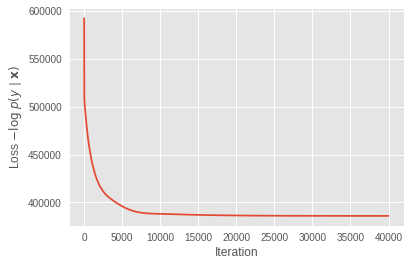

In [578]:
plt.plot(loss_history)
plt.ylabel(r'Loss $-\log$ $p(y\mid\mathbf{x})$')
plt.xlabel('Iteration')
plt.show()

We also use a trace plot, which shows the Markov chain Monte Carlo algorithm's trajectory across specific latent dimensions. Below we see that specific sublist effects indeed meaningfully transition away from their initial state and explore the state space. The trace plot also indicates that the effects differ across subjects but with similar mixing behavior.

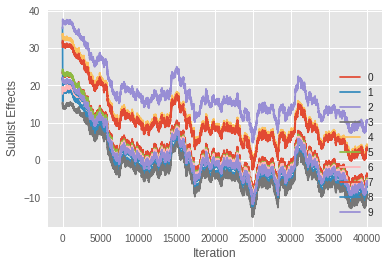

In [579]:
for i in range(10):
  plt.plot(effect_sublist_samples[:, i])

plt.legend([i for i in range(10)], loc='lower right')
plt.ylabel('Sublist Effects')
plt.xlabel('Iteration')
plt.show()

In [0]:
# all_features = ['avgDepthSol', 'avgEdgeSol', 'avgMaxCycleSol', 'avgNodeSol', 
#                    'avgcNodeSol', 'avgnCycleSol', 'backMoveSol', 'edgeRate',
#                    'nodeRate', 'unsafeSol', 'intercept']
# plt.plot(effect_avgDepthSol_samples, label=all_features[0])

# plt.legend(loc='lower right')
# plt.ylabel('Fixed Effects')
# plt.xlabel('Iteration')
# plt.show()

## Criticism

Above, we fitted the model. We now look into criticizing its fit using data, which lets us explore and better understand the model. One such technique is a residual plot, which plots the difference between the model's predictions and ground truth for each data point. If the model were correct, then their difference should be standard normally distributed; any deviations from this pattern in the plot indicate model misfit.

We build the residual plot by first forming the posterior predictive distribution over ratings, which replaces the prior distribution on the random effects with its posterior given training data. In particular, we run the model forward and intercept its dependence on prior random effects with their inferred posterior means.²

In [0]:
def interceptor(rv_constructor, *rv_args, **rv_kwargs):
  """Replaces prior on effects with empirical posterior mean from MCMC."""
  name = rv_kwargs.pop("name")
  if name == "effect_sublist":
    rv_kwargs["value"] = np.mean(effect_sublist_samples, 0)
  elif name == "effect_else":
    rv_kwargs["value"] = np.mean(effect_else_samples, 0)
  return rv_constructor(*rv_args, **rv_kwargs)

with ed.interception(interceptor):
  humanlen_posterior = model_template(features=features_test)

humanlen_prediction = humanlen_posterior.distribution.mean()

Upon visual inspection, the residuals look somewhat standard-normally distributed. However, the fit is not perfect: there is larger probability mass in the tails than a normal distribution, which indicates the model might improve its fit by relaxing its normality assumptions.

In particular, although it is most common to use a normal distribution to model humanlen in the RushHour data set, if humanlen were in ordinal distribution, or Categorical, this is a one-line change to the Edward program above; the same inference code is applicable.

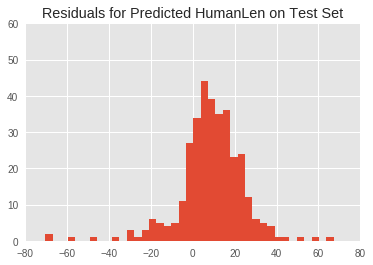

In [582]:
humanlen_pred = sess.run(humanlen_prediction)
plt.title("Residuals for Predicted HumanLen on Test Set")
plt.xlim(-80, 80)
plt.ylim(0, 60)
plt.hist(humanlen_pred - labels_test, 75)
plt.show()

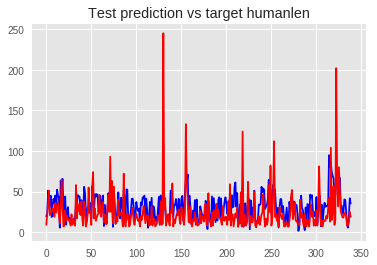

In [583]:
# visualize prediction vs target answer
plt.title("Test prediction vs target humanlen")
plt.plot(humanlen_pred, color = 'blue')
plt.plot(labels_test, color = 'red')
plt.show()

To explore how the model makes individual predictions, we look at the histogram of effects for sublist. This lets us understand how individual elements in a data point's feature vector tends to influence the outcome.

In [0]:
[
    effect_sublist_mean
] = sess.run([
    tf.reduce_mean(effect_sublist_samples, 0)
])

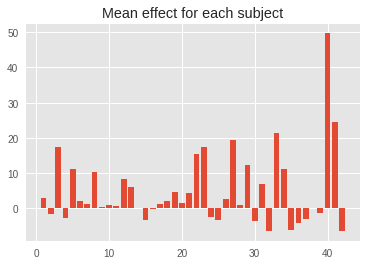

In [585]:
plt.title("Mean effect for each subject")
plt.bar(x = np.arange(num_sublist) + 1, height = effect_sublist_mean)
plt.show()

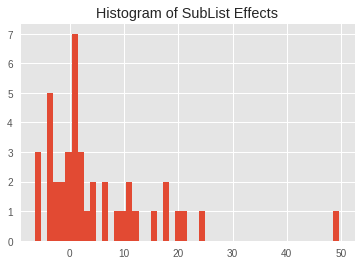

In [586]:
plt.title("Histogram of SubList Effects")
# plt.xlim(40, 110)
# plt.ylim(0, 7)
plt.hist(effect_sublist_mean, 50)
plt.show()

## Footnotes

¹ Linear mixed effect models are a special case where we can analytically compute its marginal density. For the purposes of this markdown, we demonstrate Monte Carlo EM, which more readily applies to non-analytic marginal densities such as if the likelihood were extended to be Categorical instead of Normal.

² For simplicity, we form the predictive distribution's mean using only one forward pass of the model. This is done by conditioning on the posterior mean and is valid for linear mixed effects models. However, this is not valid in general: the posterior predictive distribution's mean is typically intractable and requires taking the empirical mean across multiple forward passes of the model given posterior samples.

## Acknowledgments

[Source code](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Models.ipynb).
This markdown was originally written in Edward 1.0 ([source](https://github.com/blei-lab/edward/blob/master/notebooks/linear_mixed_effects_models.ipynb)). We thank all contributors to writing and revising that version.

## References

1. Douglas Bates and Martin Machler and Ben Bolker and Steve Walker. Fitting Linear Mixed-Effects Models Using lme4. _Journal of Statistical Software_, 67(1):1-48, 2015.

2. Arthur P. Dempster, Nan M. Laird, and Donald B. Rubin. Maximum likelihood from incomplete data via the EM algorithm. _Journal of the Royal Statistical Society, Series B (Methodological)_, 1-38, 1977.

3. Andrew Gelman and Jennifer Hill. _Data analysis using regression and multilevel/hierarchical models._ Cambridge University Press, 2006.

4. David A. Harville. Maximum likelihood approaches to variance component estimation and to related problems. _Journal of the American Statistical Association_, 72(358):320-338, 1977.

5. Michael I. Jordan. An Introduction to Graphical Models. Technical Report, 2003.

6. Nan M. Laird and James Ware. Random-effects models for longitudinal data. _Biometrics_, 963-974, 1982.

7. Greg Wei and Martin A. Tanner. A Monte Carlo implementation of the EM algorithm and the poor man's data augmentation algorithms. _Journal of the American Statistical Association_, 699-704, 1990.